In [1]:
import scipy.signal as sig
import matplotlib.pyplot as plt
import numpy as np

In [2]:
%matplotlib nbagg

In [73]:
from IPython.display import set_matplotlib_formats
%matplotlib inline

set_matplotlib_formats('png', 'pdf')

In [3]:
# Trenberth 1991
b0 = [-0.003, -0.033, -0.037, -0.013, -0.132, -0.188, 0.172, 0.468, 0.172, -0.188, -0.132, -0.013, -0.037, -0.033, -0.003]

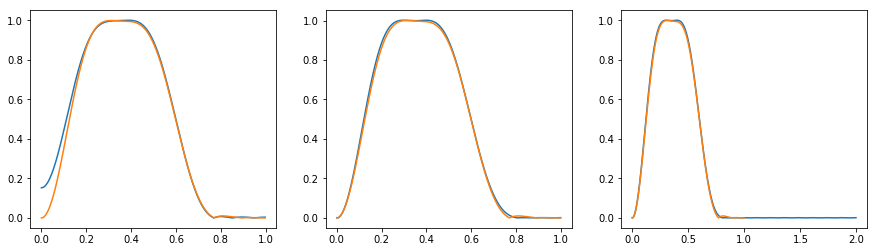

In [48]:
fig, axs = plt.subplots(1, 3, figsize=(15, 4))

# windowing method
b = sig.firwin(15, [0.11, 0.6], width=0.3, pass_zero=False)

w, h = sig.freqz(b)
axs[0].plot(w/np.pi, abs(h))
w, h = sig.freqz(b0)
axs[0].plot(w/np.pi, abs(h))

# Parks-McClellan algorithm
fs = 2
b = sig.remez(15, np.array([0, 0, 0.3, 0.42, 0.8, fs/2]), [0, 1, 0], fs=fs)
# fs/2 -> stopband must go up to Nyquist frequency

w, h = sig.freqz(b)
axs[1].plot(w*fs/2/np.pi, abs(h))
w, h = sig.freqz(b0)
axs[1].plot(w/np.pi, abs(h))

# with double the sampling frequency (4 x daily instead of 2 x)
fs = 4
b = sig.remez(31, np.array([0, 0, 0.3, 0.42, 0.8, fs/2]), [0, 1, 0], fs=fs)

w, h = sig.freqz(b)
axs[2].plot(w*fs/2/np.pi, abs(h))
w, h = sig.freqz(b0)
axs[2].plot(w/np.pi, abs(h))

<cite data-cite="2031184/7854AWU5"></cite> uses a filter whose coefficients are given above as ``b0``. His data sampling frequency is 2 x daily. I tried to reconstruct his filter by trial-and-error using different methods available in ``scipy``. I didn't get super close, but above are some of the better results.

Plots show frequency response (in day$^{-1}$) of the filters, **blue** is always my construction, **orange** the Trenberth filter.

I need to construct my own filter if I want to apply it, for example, to the reanalysis output with 4 x daily fields if I don't want to subsample first. The third panel in the figure constructs the filter for the 4 x daily frequencies, leaving all the other parameters intact.  I also doubled the number of points in the filter for the 4 x daily operation.

**Question**: Do I need to detrend before applying filter?

<IPython.core.display.Javascript object>


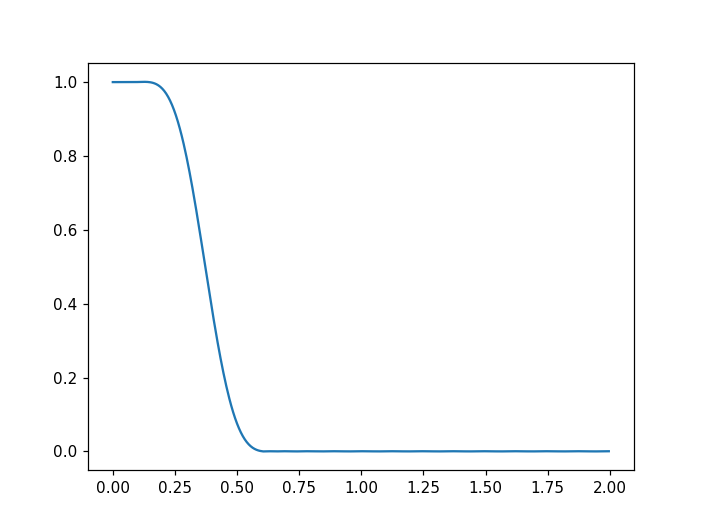

In [23]:
b = sig.remez(31, np.array([0, 0.15, 0.6, fs/2]), [1, 0], fs=fs)
fig, axs = plt.subplots()
w, h = sig.freqz(b)
axs.plot(w*fs/2/np.pi, abs(h))

<IPython.core.display.Javascript object>


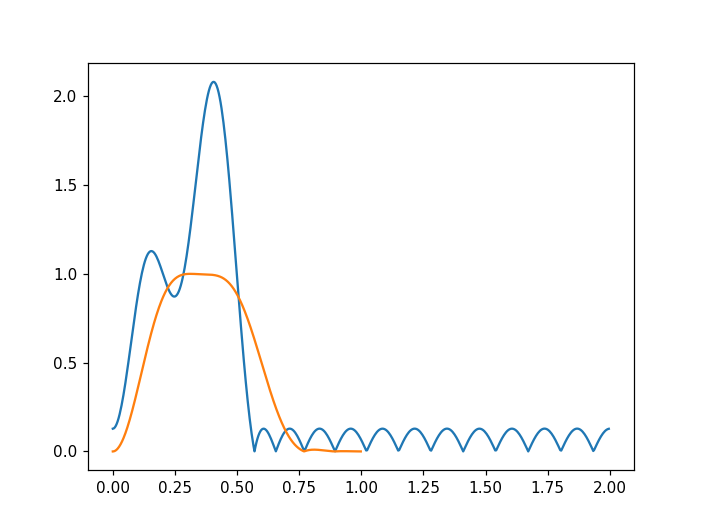

In [45]:
b = sig.remez(31, [0, 0, 0.1, 0.3, 0.6, 2], [0, 1, 0], fs=4)
fig, axs = plt.subplots()
w, h = sig.freqz(b)
axs.plot(w*2/np.pi, abs(h))
w, h = sig.freqz(b0)
axs.plot(w/np.pi, abs(h))

## Lanczos filter

$N$ is half the filter length (length is $2*N+1$, but the first and last element are zero), $a$ is a parameter for the Lanczos kernel (it takes positive integer values) - the higher $a$, the closer the filter to an ideal (sinc) filter - $a$ determines the number of zero crossings of the filter window.

The Lanczos filter is a sinc filter windowed by a sinc function ("cosine window"). The paramter $a$ also determines the frequency response if the filter is used as a lowpass filter: If $a = 1$, the cutoff period is equal to **half** the filter length (but equal to the period spanned by $N$), if $a = 2$, the cutoff period is a quarter the filter length etc.

See <cite data-cite="2031184/976JU34M"></cite>, <cite data-cite="2031184/8WPTGITU"></cite>.

In [37]:
def lanczos(N, a):
    x = np.linspace(-a, a, N)[1:-1]
    return np.sinc(x) * np.sinc(x / a)

In [49]:
x = np.linspace(0, 2*np.pi, 1000)
y = np.sin(20*x) + np.sin(50*x) # periods 50n and 20n

In [62]:
w = lanczos(101, 8)
f = np.convolve(w/w.sum(), y, 'same')

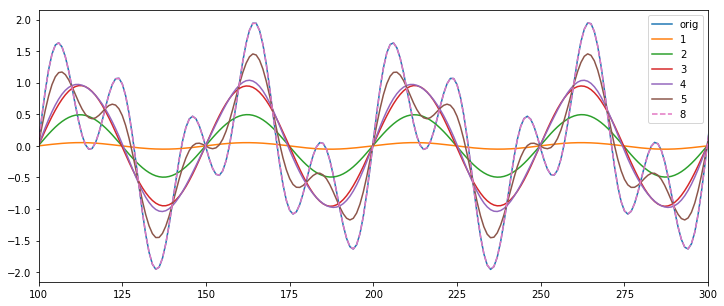

In [79]:
plt.figure(figsize=(12, 5))
plt.plot(y, label='orig')

# cutoff period N (filter length)
w = lanczos(101, 1)
plt.plot(np.convolve(w/w.sum(), y, 'same'), label='1')

# cutoff period N/2 (approx. lower frequency in data)
w = lanczos(101, 2)
plt.plot(np.convolve(w/w.sum(), y, 'same'), label='2')

# etc
w = lanczos(101, 3)
plt.plot(np.convolve(w/w.sum(), y, 'same'), label='3')

w = lanczos(101, 4)
plt.plot(np.convolve(w/w.sum(), y, 'same'), label='4')

w = lanczos(101, 5)
plt.plot(np.convolve(w/w.sum(), y, 'same'), label='5')

w = lanczos(101, 8)
plt.plot(np.convolve(w/w.sum(), y, 'same'), '--', label='8')

plt.gca().set_xlim(100, 300)
plt.legend()

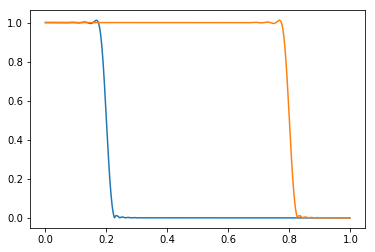

In [90]:
plt.figure()
W = lambda x: x / x.sum()
w, h = sig.freqz(W(lanczos(101, 10)))
plt.plot(w/np.pi, abs(h))
w, h = sig.freqz(W(lanczos(101, 40)))
plt.plot(w/np.pi, abs(h))